In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../modules')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from env.gridworld import GridWorldWithWallsAndTraps
from policy import EpsilonGreedyPolicy
from algo.dp import PolicyIteration

In [3]:
nrows, ncols = 10, 10

In [4]:
grid_type_array = pd.read_csv("grid_type_arrays/2.csv").fillna(0).to_numpy()[:nrows, 1:ncols+1]

In [5]:
grid_type_array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 4.],
       [0., 2., 0., 2., 0., 2., 3., 2., 3., 2.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
       [2., 0., 2., 0., 2., 0., 2., 0., 2., 0.],
       [0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
       [0., 2., 0., 2., 0., 2., 0., 2., 0., 2.],
       [0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [2., 3., 2., 0., 2., 0., 2., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 0., 2., 0., 2., 0., 2., 0., 2.]])

In [6]:
env = GridWorldWithWallsAndTraps(grid_type_array, trap_reward=-5)

q_initial_estimate = np.random.uniform(size=env.shape)
q_initial_estimate[env.end_coord] = 0
if len(env.wall_coords) > 0:
    q_initial_estimate[np.array(env.wall_coords)] = 0

policy = EpsilonGreedyPolicy(q=q_initial_estimate, epsilon=0)

algo = PolicyIteration(
    env=env, policy=policy, 
    discount_factor=1,
    truncate_pe=True, pe_tol=None,
    conv_tol=1e-16
)

algo.run(max_iterations=10000, which_tqdm='notebook')

Running DP policy iteration for at most 10000 iterations ...


Result: Convergence reached at iteration 24


In [7]:
optimal_v = algo.q.max(axis=-1)
mask = np.zeros(optimal_v.shape)
if len(env.wall_coords) > 0:
    mask[np.array(algo.env.wall_coords)[:,0], np.array(algo.env.wall_coords)[:,1]] = 1
optimal_v = np.ma.array(optimal_v, mask=mask)

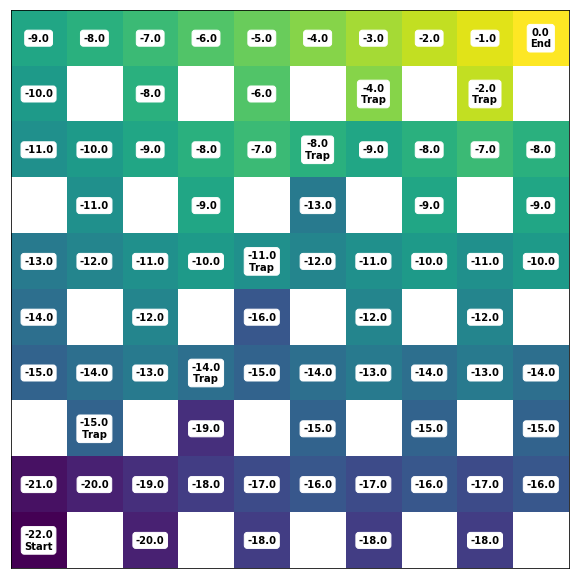

In [8]:
plt.figure(figsize=(10, 10))

cmap = cm.get_cmap('viridis')
cmap.set_bad('w')

plt.matshow(optimal_v, fignum=1, cmap=cmap)

for (i, j), z in np.ndenumerate(optimal_v):
    
    if (i, j) in algo.env.wall_coords:
        msg = ''
    else:
        if algo.env.grid_type_array[(i, j)] == 1:
            msg = '{:0.1f}\nStart'.format(z)
        elif algo.env.grid_type_array[(i, j)] == 3:
            msg = '{:0.1f}\nTrap'.format(z)
        elif algo.env.grid_type_array[(i, j)] == 4:
            msg = '{:0.1f}\nEnd'.format(z)
        else:
            msg = '{:0.1f}'.format(z)
    
    plt.text(
        j, i, msg, 
        ha='center', va='center', color="black", fontsize=10, weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='1')
    )

plt.xticks([]); plt.yticks([])
    
plt.show()